# Task 1: Demand Forecasting

Objective: Develop a demand forecasting system for a short-term period (14 days) starting 7 days after the last date in the data, for all product groups.

Description:

Using the provided transaction data, create two forecasting models:
- A machine learning model.
- A classical time series forecasting model.

Provide well-reasoned comments on the choice of methods and approaches, explaining why you chose them.

Expected Outcome:

A file with the code (.py or .ipynb) that includes two forecasting models, explanations for the choice of methods, and the ability to calculate the forecast for the future period (scoring).

For forecasting product demand, the most relevant data are from the orders and products files. Therefore, we will focus on the following files:

- order_items.csv
- orders.csv
- products.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1. Data Loading and Preprocessing

In [5]:
order_items = pd.read_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/order_items.csv')
orders = pd.read_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/orders.csv')
products = pd.read_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/products.csv')
product_category_name_translation = pd.read_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/product_category_name_translation.csv')

In [6]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [7]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [8]:
orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [9]:
all_orders = orders.shape[0]
unavailable_orders = (orders['order_status'] == 'unavailable').sum()
print(all_orders)
print(unavailable_orders)
print('% unavailable_orders from all orders', round(100*unavailable_orders/all_orders, 2))

99441
609
% unavailable_orders from all orders 0.61


In [10]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [11]:
product_category_name_translation.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


## Merging data

In [13]:
order_data = pd.merge(order_items, orders, on='order_id')
order_data = pd.merge(order_data, products, on='product_id')
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data.head()
order_data.shape

(112650, 22)

In [14]:
order_data = pd.merge(order_data, product_category_name_translation, on='product_category_name')
order_data.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-29 00:00:00,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,2017-07-26 00:00:00,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


In [15]:
order_data.drop(['product_category_name'], axis=1, inplace=True)

## Handling missing values

In [17]:
order_data.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1155
order_delivered_customer_date    2386
order_estimated_delivery_date       0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    1
product_length_cm                   1
product_height_cm                   1
product_width_cm                    1
product_category_name_english       0
dtype: int64

Filling missing values in order_approved_at with the next day after order_purchase_timestamp

In [19]:
order_data['order_approved_at'] = order_data.apply(
    lambda row: row['order_purchase_timestamp'] + pd.Timedelta(days=1) if pd.isna(row['order_approved_at']) 
    else row['order_approved_at'], axis=1)

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
order_data[['product_weight_g', 
             'product_length_cm', 
             'product_height_cm', 
             'product_width_cm']] = imputer.fit_transform(order_data[['product_weight_g',
                                                                       'product_length_cm',
                                                                       'product_height_cm',
                                                                        'product_width_cm'
                                                                       ]])
                                                                         

In [21]:
order_data['order_delivered_carrier_date'].fillna(order_data['order_estimated_delivery_date'], inplace=True)
order_data['order_delivered_customer_date'].fillna(order_data['order_estimated_delivery_date'], inplace=True)
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data['order_approved_at'] = pd.to_datetime(order_data['order_approved_at'])
order_data['order_delivered_carrier_date'] = pd.to_datetime(order_data['order_delivered_carrier_date'])
order_data['order_delivered_customer_date'] = pd.to_datetime(order_data['order_delivered_customer_date'])

In [22]:
order_data.isna().sum()

order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64

In [23]:
order_data.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-20 23:43:48,2017-09-29 00:00:00,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,2017-07-13 20:39:29,2017-07-26 00:00:00,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


## Create features for future the model

In [25]:
order_data['order_date'] = order_data['order_purchase_timestamp'].dt.date
demand_data = order_data.groupby(['order_date', 'product_id', 'price', 'product_category_name_english']).agg({'order_item_id': 'count'}).reset_index()
demand_data.rename(columns={'order_item_id': 'demand'}, inplace=True)
print(demand_data.info())
demand_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93369 entries, 0 to 93368
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_date                     93369 non-null  object 
 1   product_id                     93369 non-null  object 
 2   price                          93369 non-null  float64
 3   product_category_name_english  93369 non-null  object 
 4   demand                         93369 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 3.6+ MB
None


,order_date,product_id,price,product_category_name_english,demand
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,39.99,furniture_decor,1
1,2016-09-04,f293394c72c9b5fafd7023301fc21fc2,32.90,furniture_decor,1


## Sorting by 'product_id', 'order_date'

ensures that the lag features correctly align with the historical sales data for each product. Without sorting, the shifts could mix up data from different products or out-of-order dates, leading to incorrect lag values.

In [27]:
# Sort data by date for each product
demand_data = demand_data.sort_values(by=['product_id', 'order_date'])
demand_data.rename(columns={'product_category_name_english': 'categ'}, inplace=True)
demand_data.head(10)

,order_date,product_id,price,categ,demand
73417,2018-05-20,00066f42aeeb9f3007548bb9d3f33c38,101.65,perfumery,1
39804,2017-12-12,00088930e925c41fd95ebfe695fd2655,129.90,auto,1
41376,2017-12-21,0009406fd7479715e4bef61dd91f2462,229.00,bed_bath_table,1
87117,2018-08-01,000b8f95fcb9e0096488278317764d19,58.90,housewares,1
89810,2018-08-10,000b8f95fcb9e0096488278317764d19,58.90,housewares,1
62558,2018-04-03,000d9be29b5207b54e86aa1b1ac54872,199.00,watches_gifts,1
40239,2017-12-14,0011c512eb256aa0dbbb544d8dffcf6e,52.00,auto,1
24248,2017-09-17,00126f27c813603687e6ce486d909d01,249.00,cool_stuff,2
30041,2017-10-28,001795ec6f1b187d37335e1c4704762e,38.90,consoles_games,1
35358,2017-11-25,001795ec6f1b187d37335e1c4704762e,38.90,consoles_games,1


## Savw the data

In [33]:
demand_data.to_csv('/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/demand_data_pp.csv', index=False)

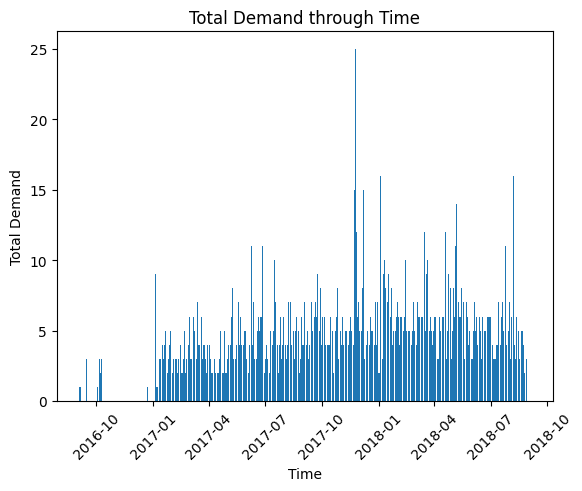

In [29]:
# Plot for all demand
plt.bar(demand_data['order_date'], demand_data['demand'])
plt.xlabel('Time')
plt.ylabel('Total Demand')
plt.title('Total Demand through Time')
plt.xticks(rotation=45) 
plt.show()

The plot shows the distribution of the 'demand', varying from 0 to approximately 25. This confirms that the demand has high variability, with many peaks and troughs. Such variability can be caused by seasonality, holidays, promotions, or other factors.